# Choroid Plexus and CSF

## Set Up

### Imports

In [2]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace


In [3]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors, run_R_script
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [4]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/3-CP_CSF_analysis"
)

data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)
dataT = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
    index_col="subid",
)

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

### Functions

In [5]:
def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["posterior", "medial", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"THALAMUS_1 vs {struct}"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"THALAMUS_1 vs {struct}"] >= 0.05:
            sign = "="
        elif abs(pearson_results["THALAMUS_1"][0]) > abs(pearson_results[struct][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps

In [6]:
# %%html
# <style>
#     body {
#         --vscode-font-family: "FiraCode Nerd Font", "Source Sans 3", "Georgia", sans-serif; /* Fallback font included */
#     }
# </style>

## Analysis

Peripheral CSF segmentation was obtained starting from the `FAST` CSF segmentation, then subtracting the lateral, third, and fourth ventricles and also label 24 from Freesurfer's `aseg.auto_noCCseg` segmentation (technically Fastsurfer's)

Peripheral CSF segmentation was obtained starting from the `FAST` CSF segmentation, then subtracting the lateral, third, and fourth ventricles and also label 24 from Freesurfer's `aseg.auto_noCCseg` segmentation (technically Fastsurfer's)

### Does CP drive central atrophy?

Previous analysis showed that CP is very strongly associated with LV; in fact, of all the variables I'm looking at, LV is the one with the strongest association with CP. Both CP and LV enlarge in MS. We know that LV enlargement can be indicative of a few different pathologic processes.

1. Overproduction of CSF
2. Atrophy
3. CSF obstruction

Also, atrophy associated with ventricular enlargement could be global or central. 

*why would it be interesting to determine that global versus local atrophy is occuring?*

#### Relationship between CP and CSF compartment volumes

**Does CP predict the volume of the third ventricle, fourth ventricle, and peripheral CSF, and which ones is it most strongly associated with?**

- CP has the strongest relationship with the LV's, then aseg label 24\*, then the third ventricle, and finally the fourth ventricle. 

\**Freesurfer's aseg segmentation has a label 24 called "CSF" which is a misnomer because it is actually pretty small and located at some periaqueductal/interthalamic CSF pocket.*

In [ ]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

test_outcomes = ["LV_log", "asegCSF_log", "thirdV_log", "fourthV_log", "periCSF"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
covariates = ["age", "Female", "tiv"]

_, results = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
results_present = results[predictor_to_show].rename(
    index={
        "asegCSF_log": "aseg24_CSF_log",
        "thirdV_log": "aseg14_thirdV",
        "fourthV_log": "aseg15_fourthV",
    }
)

display(Markdown(f"**Effect of {predictor_to_show} on outcomes**"))
display(Markdown(f"`{formula}`"))
display(
    Markdown(regutils.present_model(results_present, presentation_cols).to_markdown())
)

**Effect of CP on outcomes**

`outcome ~ CP + age + Female + tiv`

| outcome        |     coef |       p_fdr |        pval |        se | ci              |       R2 |
|:---------------|---------:|------------:|------------:|----------:|:----------------|---------:|
| LV_log         | 0.614809 | 1.2497e-57  | 2.4994e-58  | 0.0329473 | [0.55, 0.68]    | 0.5506   |
| aseg24_CSF_log | 0.467637 | 6.2161e-23  | 2.48644e-23 | 0.0444713 | [0.38, 0.555]   | 0.268494 |
| aseg14_thirdV  | 0.42644  | 1.79606e-21 | 1.07763e-21 | 0.04235   | [0.343, 0.51]   | 0.351978 |
| aseg15_fourthV | 0.230005 | 7.7619e-06  | 6.20952e-06 | 0.0503067 | [0.131, 0.329]  | 0.141303 |
| periCSF        | 0.149099 | 2.63261e-05 | 2.63261e-05 | 0.0351154 | [0.0801, 0.218] | 0.575018 |

CP also predicts these CSF volumes after accounting for both brain and thalamus volumes.

In [7]:
covariates = ["brain", "THALAMUS_1", "age", "Female", "tiv"]

_, results = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
results_present = results[predictor_to_show].rename(
    index={
        "asegCSF_log": "aseg24_CSF_log",
        "thirdV_log": "aseg14_thirdV",
        "fourthV_log": "aseg15_fourthV",
    }
)

display(Markdown(f"**Effect of {predictor_to_show} on outcomes after accounting for brain and THALAMUS_1 as well**"))
display(Markdown(f"`{formula}`"))
display(
    Markdown(regutils.present_model(results_present, presentation_cols).to_markdown())
)

**Effect of CP on outcomes after accounting for brain and THALAMUS_1 as well**

`outcome ~ CP + brain + THALAMUS_1 + age + Female + tiv`

| outcome        |      coef |       p_fdr |        pval |        se | ci               |       R2 |
|:---------------|----------:|------------:|------------:|----------:|:-----------------|---------:|
| LV_log         | 0.442739  | 3.05787e-28 | 6.11575e-29 | 0.0369813 | [0.37, 0.515]    | 0.654968 |
| aseg24_CSF_log | 0.285222  | 8.53042e-09 | 3.41217e-09 | 0.0473176 | [0.192, 0.378]   | 0.366487 |
| aseg14_thirdV  | 0.218892  | 3.69209e-07 | 2.21525e-07 | 0.0416167 | [0.137, 0.301]   | 0.480878 |
| aseg15_fourthV | 0.134604  | 0.0229638   | 0.018371    | 0.0568791 | [0.0228, 0.246]  | 0.16454  |
| periCSF        | 0.0431949 | 0.240852    | 0.240852    | 0.0367811 | [-0.0291, 0.115] | 0.621277 |

The following is more of a sanity check. If all the CSF volumes are defined properly, particulary peripheral CSF, we'd expect thalamic volume to be related to the central CSF compartments and for brain volume to be related to the peripheral CSF volume. This is borne out. Peripheral CSF has a much stronger relationship to WBV and LV has a much stronger relationship to thalamus

In [16]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

rename_index = {
    "brain": "**brain**",
    "THALAMUS_1": "**THALAMUS_1**"
}

test_outcomes = ["LV_log", "thirdV_log", "fourthV_log", "periCSF"]
all_results = defaultdict(dict)
all_models = defaultdict(dict)
all_formulas = defaultdict(dict)
for outcome in test_outcomes:
    formula_list = {
        "brain": f"{outcome} ~ brain + age + Female + tiv",
        "thalamus": f"{outcome} ~ THALAMUS_1 + age + Female + tiv",
        "brain+thalamus": f"{outcome} ~ brain + THALAMUS_1 + age + Female + tiv"
    }
    
    all_results[outcome], all_models[outcome], all_formulas[outcome] = regutils.run_regressions3(
        model_data_z,
        formula_list.values(),
        model_names=formula_list.keys()
    )
    
outcome = "periCSF"
display(Markdown(f"### {outcome}"))
results = all_results[outcome]
formulas = all_formulas[outcome]

model_name = "thalamus"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"#### {model_name}"))
display(Markdown(f"`{formula}`"))
display(Markdown(regutils.present_model(model, presentation_cols,
                                        rename_index=rename_index).to_markdown()))
display(Markdown("---"))
model_name = "brain+thalamus"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"#### {model_name}"))
display(Markdown(f"`{formula}`"))
display(Markdown(regutils.present_model(model, presentation_cols,
                                        rename_index=rename_index).to_markdown() + "\n\n"))
display(Markdown("---"))


outcome = "LV_log"
display(Markdown(f"### {outcome}"))
results = all_results[outcome]
formulas = all_formulas[outcome]

model_name = "brain"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"#### {model_name}"))
display(Markdown(f"`{formula}`"))
display(Markdown(regutils.present_model(model, presentation_cols,
                                        rename_index=rename_index).to_markdown()))
display(Markdown("---"))

model_name = "brain+thalamus"
model = results[model_name]
formula = formulas[model_name]

display(Markdown(f"#### {model_name}"))
display(Markdown(f"`{formula}`"))
display(Markdown(regutils.present_model(model, presentation_cols,
                                        rename_index=rename_index).to_markdown()))
display(Markdown("---"))

### periCSF

#### thalamus

`periCSF ~ THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci                |
|:---------------|--------:|--------:|-------:|:------------------|
| Intercept      |  0.0025 | 0.93    | 0.03   | [-0.0565, 0.0615] |
| **THALAMUS_1** | -0.2024 | 2.9e-06 | 0.0427 | [-0.286, -0.118]  |
| age            |  0.131  | 9.3e-05 | 0.0332 | [0.0657, 0.196]   |
| Female         |  0.0534 | 0.15    | 0.0371 | [-0.0196, 0.126]  |
| tiv            |  0.8329 | 5.9e-67 | 0.0406 | [0.753, 0.913]    |

---

#### brain+thalamus

`periCSF ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci                |
|:---------------|--------:|--------:|-------:|:------------------|
| Intercept      |  0.003  | 0.92    | 0.0288 | [-0.0535, 0.0595] |
| **brain**      | -0.2327 | 1.8e-10 | 0.0356 | [-0.303, -0.163]  |
| **THALAMUS_1** | -0.111  | 0.012   | 0.0441 | [-0.198, -0.0243] |
| age            |  0.0614 | 0.072   | 0.0341 | [-0.00554, 0.128] |
| Female         |  0.0814 | 0.02    | 0.0349 | [0.0128, 0.15]    |
| tiv            |  0.8334 | 3.7e-75 | 0.0374 | [0.76, 0.907]     |



---

### LV_log

#### brain

`LV_log ~ brain + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  0.0027 | 0.95    | 0.0391 | [-0.0742, 0.0795] |
| **brain** | -0.2473 | 8.2e-08 | 0.0454 | [-0.336, -0.158]  |
| age       |  0.3239 | 2.9e-12 | 0.0451 | [0.235, 0.413]    |
| Female    | -0.0268 | 0.53    | 0.0428 | [-0.111, 0.0573]  |
| tiv       |  0.2572 | 8.9e-08 | 0.0473 | [0.164, 0.35]     |

---

#### brain+thalamus

`LV_log ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci               |
|:---------------|--------:|--------:|-------:|:-----------------|
| Intercept      |  0.0024 | 0.94    | 0.0318 | [-0.0602, 0.065] |
| **brain**      | -0.0171 | 0.68    | 0.0412 | [-0.0981, 0.064] |
| **THALAMUS_1** | -0.6258 | 4.1e-48 | 0.0381 | [-0.701, -0.551] |
| age            |  0.2174 | 2.1e-09 | 0.0356 | [0.148, 0.287]   |
| Female         |  0.0318 | 0.41    | 0.0385 | [-0.0439, 0.107] |
| tiv            |  0.5091 | 3.4e-28 | 0.0432 | [0.424, 0.594]   |

---

#### CP drives preferential central expansion

With the degree of preferential central expansion defined as the central CSF ratio (CCR):

$CCR = LV / periCSF$

**CP is associated with increasing CCR, beyond what is predicted by brain or thalamus volumes.**

In [18]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

test_outcomes = ["CCR_log"]
predictors = ["CP"]
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

_, results, formulas = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
display(Markdown(f"`{formula}`"))
display(
    Markdown(
        regutils.present_model(
            results[predictor_to_show], presentation_cols
        ).to_markdown()
    )
)


test_outcomes = ["CCR_log"]
predictors = ["CP"]
covariates = ["brain", "age", "Female", "tiv"]

_, results, formulas = regutils.run_regressions(
    model_data_z, test_outcomes, predictors, covariates=covariates
)

predictor_to_show = "CP"
formula = regutils.formula_string("outcome", predictor_to_show, covariates)
display(Markdown(f"`{formula}`"))
display(
    Markdown(
        regutils.present_model(
            results[predictor_to_show], presentation_cols
        ).to_markdown()
    )
)


`outcome ~ CP + THALAMUS_1 + age + Female + tiv`

| outcome   |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:----------|-------:|--------:|--------:|-------:|:---------------|-----:|
| CCR_log   | 0.4308 | 9.3e-25 | 9.3e-25 | 0.0395 | [0.353, 0.509] | 0.57 |

`outcome ~ CP + brain + age + Female + tiv`

| outcome   |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:----------|-------:|--------:|--------:|-------:|:---------------|-----:|
| CCR_log   | 0.5989 | 1.1e-42 | 1.1e-42 | 0.0393 | [0.522, 0.676] | 0.48 |

Alternative presentation for the above

In [21]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

outcome = "CCR_log"

exog_list = {
    "CP alone": ["CP"],
    "CP, control for brain": ["CP", "brain"],
    "CP, control for thalamus": ["CP", "THALAMUS_1"],
    "Just brain": ["brain"],
    "Just thalamus": ["THALAMUS_1"],
    "t2lv and brain": ["t2lv_log", "brain"],
    "t2lv and thalamus": ["t2lv_log", "THALAMUS_1"],
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))
    display(Markdown("---"))


# _, results = regutils.run_regressions(
#     model_data_z, test_outcomes, predictors, covariates=covariates
# )

# predictor_to_show = "CP"
# formula = regutils.formula_string("outcome", predictor_to_show, covariates)
# display(Markdown(f"**Effect of {predictor_to_show} on outcome**"))
# display(Markdown(f"`{formula}`"))

# results[predictor_to_show]

#### CP alone

`CCR_log ~ CP + age + Female + tiv`

|           |   coef |    pval |     se | ci               |
|:----------|-------:|--------:|-------:|:-----------------|
| Intercept | 0.0013 | 0.97    | 0.0337 | [-0.065, 0.0676] |
| CP        | 0.6048 | 5.5e-51 | 0.0354 | [0.535, 0.674]   |
| age       | 0.1845 | 5.1e-06 | 0.04   | [0.106, 0.263]   |
| Female    | 0.0478 | 0.21    | 0.0382 | [-0.0272, 0.123] |
| tiv       | 0.0551 | 0.19    | 0.0423 | [-0.028, 0.138]  |

---

#### CP, control for brain

`CCR_log ~ CP + brain + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  0.0014 | 0.97    | 0.0338 | [-0.0651, 0.0678] |
| CP        |  0.5989 | 1.1e-42 | 0.0393 | [0.522, 0.676]    |
| brain     | -0.0201 | 0.63    | 0.0416 | [-0.102, 0.0616]  |
| age       |  0.1781 | 1.3e-05 | 0.0404 | [0.0988, 0.257]   |
| Female    |  0.0503 | 0.18    | 0.0376 | [-0.0236, 0.124]  |
| tiv       |  0.0591 | 0.16    | 0.042  | [-0.0235, 0.142]  |

---

#### CP, control for thalamus

`CCR_log ~ CP + THALAMUS_1 + age + Female + tiv`

|            |    coef |    pval |     se | ci                |
|:-----------|--------:|--------:|-------:|:------------------|
| Intercept  |  0.0016 | 0.96    | 0.0305 | [-0.0584, 0.0616] |
| CP         |  0.4308 | 9.3e-25 | 0.0395 | [0.353, 0.509]    |
| THALAMUS_1 | -0.4118 | 2.2e-19 | 0.0437 | [-0.498, -0.326]  |
| age        |  0.1134 | 0.0012  | 0.0349 | [0.0448, 0.182]   |
| Female     |  0.0774 | 0.032   | 0.0361 | [0.00652, 0.148]  |
| tiv        |  0.2565 | 5.7e-09 | 0.0432 | [0.172, 0.341]    |

---

#### Just brain

`CCR_log ~ brain + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  0.0022 | 0.96    | 0.0412 | [-0.0788, 0.0832] |
| brain     | -0.2048 | 1.9e-05 | 0.0474 | [-0.298, -0.112]  |
| age       |  0.3186 | 6.2e-11 | 0.0476 | [0.225, 0.412]    |
| Female    | -0.0427 | 0.34    | 0.0448 | [-0.131, 0.0453]  |
| tiv       |  0.1186 | 0.016   | 0.049  | [0.0223, 0.215]   |

---

#### Just thalamus

`CCR_log ~ THALAMUS_1 + age + Female + tiv`

|            |    coef |    pval |     se | ci                |
|:-----------|--------:|--------:|-------:|:------------------|
| Intercept  |  0.002  | 0.95    | 0.0344 | [-0.0655, 0.0695] |
| THALAMUS_1 | -0.6155 | 1.7e-49 | 0.0368 | [-0.688, -0.543]  |
| age        |  0.2046 | 3.4e-08 | 0.0364 | [0.133, 0.276]    |
| Female     |  0.0189 | 0.64    | 0.0403 | [-0.0602, 0.098]  |
| tiv        |  0.3704 | 3.9e-15 | 0.0455 | [0.281, 0.46]     |

---

#### t2lv and brain

`CCR_log ~ t2lv_log + brain + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  0.0026 | 0.95    | 0.0378 | [-0.0716, 0.0768] |
| t2lv_log  |  0.383  | 3.2e-12 | 0.0535 | [0.278, 0.488]    |
| brain     | -0.1484 | 0.0014  | 0.0461 | [-0.239, -0.0579] |
| age       |  0.2247 | 7.6e-08 | 0.0411 | [0.144, 0.306]    |
| Female    | -0.0507 | 0.24    | 0.0434 | [-0.136, 0.0345]  |
| tiv       |  0.0842 | 0.076   | 0.0474 | [-0.00888, 0.177] |

---

#### t2lv and thalamus

`CCR_log ~ t2lv_log + THALAMUS_1 + age + Female + tiv`

|            |    coef |    pval |     se | ci                |
|:-----------|--------:|--------:|-------:|:------------------|
| Intercept  |  0.0022 | 0.95    | 0.034  | [-0.0646, 0.0689] |
| t2lv_log   |  0.159  | 0.006   | 0.0576 | [0.0457, 0.272]   |
| THALAMUS_1 | -0.5213 | 7.1e-23 | 0.0502 | [-0.62, -0.423]   |
| age        |  0.1865 | 2.6e-07 | 0.0357 | [0.116, 0.257]    |
| Female     |  0.0047 | 0.91    | 0.0399 | [-0.0737, 0.0832] |
| tiv        |  0.3161 | 3.5e-11 | 0.0466 | [0.225, 0.408]    |

---

##### CP fully mediates the relationship between brain and CCR.

CP enlargement appeared to account for the relationship between whole brain atrophy and central CSF predominance. While brain volume alone predicted CCF (β*=-0.204, p<0.001), this association became non-significant when CP was included in the model (β*=-0.020, p=0.63), suggesting CP-associated processes mediate the central component of brain atrophy. This contrasts with T2 lesion volume, which showed independent effects alongside brain volume (both p<0.001), consistent with T2 lesions representing more diffuse pathology.

In [22]:
p2 = Process(
    data=model_data_z,
    model=4,
    x="brain",
    y="CCF",
    m=["CP"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

print("="*80)
print(mediation)
print("="*80)



Direct effect of brain on CCF:

  Effect     SE       t      p    LLCI   ULCI
 -0.0651 0.0453 -1.4376 0.1512 -0.1538 0.0236

Indirect effect of brain on CCF:

      Effect  Boot SE  BootLLCI  BootULCI
  CP -0.1409   0.0250   -0.1924   -0.0964




#### CCR increases in MS

Is CCR specific for MS pathology? Logistic regression of MS status on CCR, controlling for age, sex, and tiv. CCR is increased in MS patients

In [36]:
model_data = dataT.copy()[(MS_patients) | (NONMS_patients)]
model_data_z = zscore(model_data)
model_data_z = model_data_z.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

outcome = "MS" # LV / allCSF
covariates = ["age", "Female", "tiv"]

predictors = {
    "CCR_log": ["CCR_log"],
    "periCSF": ["periCSF"],
    "periCSF_ratio_log": ["periCSF_ratio_log"]
}
    

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    predictors.values(),
    model_names=predictors.keys(),
    covariates=covariates,
    regression_model=sm.Logit
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))
    

# model_name = predictors[0]
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


#### CCR_log

`MS ~ CCR_log + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6898 | 1.4e-44 | 0.1206 | [1.45, 1.93]      |
| CCR_log   |  0.3064 | 0.021   | 0.1323 | [0.0472, 0.566]   |
| age       | -0.3078 | 0.02    | 0.1324 | [-0.567, -0.0482] |
| Female    | -0.286  | 0.048   | 0.1448 | [-0.57, -0.00224] |
| tiv       | -0.4162 | 0.0033  | 0.1415 | [-0.693, -0.139]  |

#### periCSF

`MS ~ periCSF + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6632 | 3.2e-45 | 0.1179 | [1.43, 1.89]      |
| periCSF   |  0.0556 | 0.75    | 0.1774 | [-0.292, 0.403]   |
| age       | -0.1896 | 0.12    | 0.1228 | [-0.43, 0.0511]   |
| Female    | -0.2993 | 0.037   | 0.1438 | [-0.581, -0.0173] |
| tiv       | -0.4026 | 0.033   | 0.1887 | [-0.772, -0.0328] |

#### periCSF_ratio_log

`MS ~ periCSF_ratio_log + age + Female + tiv`

|                   |    coef |    pval |     se | ci                |
|:------------------|--------:|--------:|-------:|:------------------|
| Intercept         |  1.6898 | 1.4e-44 | 0.1206 | [1.45, 1.93]      |
| periCSF_ratio_log | -0.3064 | 0.021   | 0.1323 | [-0.566, -0.0472] |
| age               | -0.3078 | 0.02    | 0.1324 | [-0.567, -0.0482] |
| Female            | -0.286  | 0.048   | 0.1448 | [-0.57, -0.00224] |
| tiv               | -0.4162 | 0.0033  | 0.1415 | [-0.693, -0.139]  |

In [38]:
model_data = dataT.copy()[(MS_patients) | (NONMS_patients)]
model_data_z = zscore(model_data)
model_data_z = model_data_z.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

outcome = "MS" # LV / allCSF
covariates = ["age", "Female", "tiv"]

predictors = {
    "ventral": ["ventral", "THALAMUS_1", "CP"],
    "posterior": ["posterior", "THALAMUS_1", "CP"],}
    

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    predictors.values(),
    model_names=predictors.keys(),
    covariates=covariates,
    regression_model=sm.Logit
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))
    

# model_name = predictors[0]
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


#### ventral

`MS ~ ventral + THALAMUS_1 + CP + age + Female + tiv`

|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| Intercept  |  1.9557 | 6.4e-39 | 0.1499 | [1.66, 2.25]     |
| ventral    |  0.9197 | 0.0075  | 0.3437 | [0.246, 1.59]    |
| THALAMUS_1 | -2.0051 | 3.2e-07 | 0.3922 | [-2.77, -1.24]   |
| CP         | -0.2491 | 0.11    | 0.1555 | [-0.554, 0.0558] |
| age        | -0.5333 | 0.00025 | 0.1457 | [-0.819, -0.248] |
| Female     | -0.2204 | 0.15    | 0.1537 | [-0.522, 0.0809] |
| tiv        |  0.0153 | 0.94    | 0.1912 | [-0.359, 0.39]   |

#### posterior

`MS ~ posterior + THALAMUS_1 + CP + age + Female + tiv`

|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| Intercept  |  1.9801 | 1.5e-38 | 0.1525 | [1.68, 2.28]     |
| posterior  | -1.4295 | 0.0012  | 0.4418 | [-2.3, -0.564]   |
| THALAMUS_1 |  0.1994 | 0.67    | 0.4706 | [-0.723, 1.12]   |
| CP         | -0.1835 | 0.22    | 0.1498 | [-0.477, 0.11]   |
| age        | -0.5716 | 0.0001  | 0.1474 | [-0.86, -0.283]  |
| Female     | -0.2598 | 0.098   | 0.1572 | [-0.568, 0.0483] |
| tiv        | -0.0201 | 0.92    | 0.1929 | [-0.398, 0.358]  |

---

(array([  6.,  14.,  36.,  66., 108., 141., 113.,  56.,  22.,   1.]),
 array([1.13793955, 1.46772522, 1.7975109 , 2.12729658, 2.45708225,
        2.78686793, 3.11665361, 3.44643928, 3.77622496, 4.10601064,
        4.43579631]),
 <BarContainer object of 10 artists>)

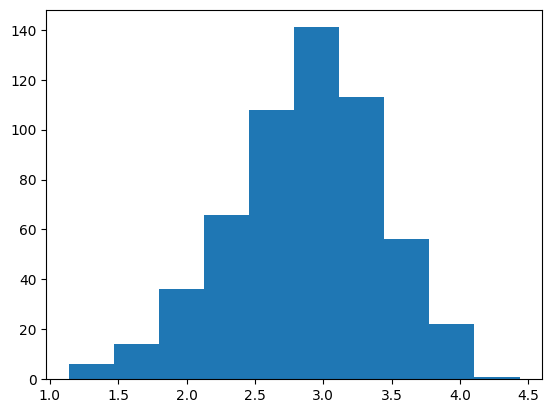

In [34]:
plt.hist(data['periCSF_ratio_log'])